# Hälsostudie

Vi vill använda oss av statistik inferens för att denna hälsostudie med information om deltagarnas ålder, kön, vikt, längd, blodtryck, kolesterolnivå, rökvanor och om de har en viss sjukdom för att göra analys och dra statistiksa slutsatser om deras hälsotillstånd.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Förhandsgranska data

Vi vill börja förhandsgranska våra data för att få en första förståelse av hur datasetet ser ut och om det finns eventuella problem.
Genom att använda df.head(), df.describe() och df.info() kan vi se exempel på observationer, få en statistisk sammanfattning samt information om datatyper och antal värden.
Med df.isna().sum() undersöker vi dessutom om det finns saknade värden som kan behöva hanteras innan vidare analys.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*

In [2]:
# Öppnar och läser filen
df = pd.read_csv("health_study_dataset.csv")

# Förhandsgranskar datan
display(df.head())
display(df.describe())
display(df.info())

df.isna().sum()

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


,id,age,height,weight,systolic_bp,cholesterol,disease
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,49.426250,171.849250,73.413000,149.178625,4.929150,0.058750
std,231.0844,14.501118,9.804259,13.685059,12.793360,0.848413,0.235303
min,1.0000,18.000000,144.400000,33.700000,106.800000,2.500000,0.000000
25%,200.7500,39.000000,164.775000,64.800000,140.900000,4.327500,0.000000
50%,400.5000,50.000000,171.350000,73.200000,149.400000,4.970000,0.000000
75%,600.2500,59.000000,178.925000,82.600000,157.600000,5.482500,0.000000
max,800.0000,90.000000,200.400000,114.400000,185.900000,7.880000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


None

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64

## Beskrivande analys

Vi vill undersöka våra data genom en beskrivande analys för att få en överblick över centrala mått och fördelningar.
Vi vill därför räkna ut medelvärde, median, minimum och maximum för variablerna age, weight, height, systolic_bp och cholesterol.
Dessutom vill vi visualisera resultaten genom tre olika grafer som ger en översikt över rökning, blodtryck och vikt hos populationen från datasetet. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for Geeks](https://www.geeksforgeeks.org/python/how-to-make-a-table-in-python/)*

### Översikt - Statistik för hälsodata

In [3]:
# Tar fram statistik för hälsodata
columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]
data = df[columns]

statistics = pd.DataFrame({
    "Medel": data.mean(),
    "Median": data.median(),
    "Min": data.min(),
    "Max": data.max()
}).round(2)

statistics.style \
    .set_caption("<h2> Översikt - Statistik för hälsodata") \
    .format("{:.2f}")

,Medel,Median,Min,Max
age,49.43,50.00,18.00,90.00
weight,73.41,73.20,33.70,114.40
height,171.85,171.35,144.40,200.40
systolic_bp,149.18,149.40,106.80,185.90
cholesterol,4.93,4.97,2.50,7.88


### Översikt över rökning, blodtryck och vikt

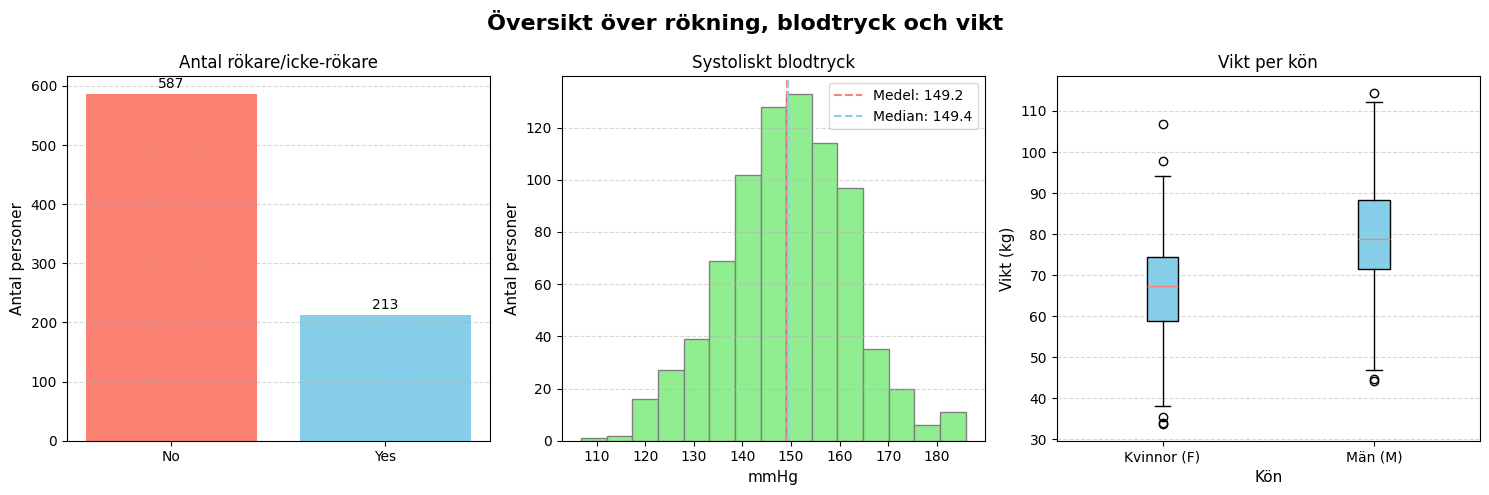

In [4]:
# Skapar en figure med 1 rad och 3 kolumner (grafer)
# ========================
figs, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# SUBPLOT 1: Bar chart för rökare
# ========================
ax1 = axes[0]
counts = df["smoker"].value_counts()
bars = ax1.bar(counts.index, counts.values, color=['salmon', 'skyblue'])

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

ax1.set_title("Antal rökare/icke-rökare", fontsize=12)
ax1.set_ylabel("Antal personer", fontsize=11)
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)
ax1.tick_params(axis='x')

# SUBPLOT 2: Histogram systoliskt blodtryck
# ========================
ax2 = axes[1]
ax2.hist(df["systolic_bp"], bins=15, color="lightgreen", edgecolor="grey")

mean_bp = df["systolic_bp"].mean()
median_bp = df["systolic_bp"].median()

ax2.axvline(mean_bp, color='salmon', linestyle='dashed', linewidth=1.5, label=f'Medel: {mean_bp:.1f}')
ax2.axvline(median_bp, color='skyblue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bp:.1f}')

ax2.set_title("Systoliskt blodtryck", fontsize=12)
ax2.set_xlabel("mmHg", fontsize=11)
ax2.set_ylabel("Antal personer", fontsize=11)
ax2.grid(True, axis="y", linestyle="--", alpha=0.5)
ax2.legend()

# SUBPLOT 3: Boxplot över vikt per kön
# ========================
ax3 = axes[2]
ax3.boxplot(
    [df.loc[df['sex'] == 'F', 'weight'], df.loc[df['sex'] == 'M', 'weight']],
    tick_labels=["Kvinnor (F)", "Män (M)"],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='salmon', linewidth=1)
)

ax3.set_title("Vikt per kön", fontsize=12)
ax3.set_xlabel("Kön", fontsize=11)
ax3.set_ylabel("Vikt (kg)", fontsize=11)
ax3.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Översikt över rökning, blodtryck och vikt", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Individer med sjukdomen

Vi vill undersöka andelen personer i vårt dataset som har sjukdomen.
Vi vill därför simulera 1000 slumpmässigt valda personer med samma sannolikhet för sjukdom med hjälp av NumPy.
Slutligen vill vi jämföra den simulerade andelen med den verkliga andelen i datasetet för att se hur väl simuleringen stämmer överens med "verkligheten".

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for Geeks - Pie Chart](https://www.geeksforgeeks.org/data-science/plot-a-pie-chart-in-python-using-matplotlib/)*, *[Geeks for geeks - random.seed()](https://www.geeksforgeeks.org/python/random-seed-in-python/)*

### Andel personer med och utan sjukdomen

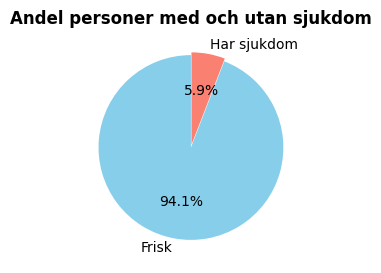

In [5]:
# Skapar ett cirkeldiagram
# ========================
disease_counts = df["disease"].value_counts().sort_index()

plt.figure(figsize=(3, 3))
plt.pie(
    disease_counts.values,
    labels=["Frisk", "Har sjukdom"],
    autopct="%1.1f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    explode=(0, 0.03)
)
plt.title("Andel personer med och utan sjukdom", fontsize=12, fontweight='bold')
plt.show()

### Sanolikheten att insjukna

Vi vill ta reda på hur väl en slumpmässig simulering av 1000 personer (baserad på den observerade sannolikheten för sjukdom) stämmer överens med den verkliga andelen i datasetet.

In [6]:
# Simulerar sannolikheten för sjukdomen - jämför med den verkliga andelen i datasetet

# 1. Verklig andel 
# ========================
disease_part = df["disease"].value_counts()
true_proportion = disease_part[1] / disease_part.sum()
print(f"Andelen med sjukdomen: {true_proportion:.1%}")

# 2. Simulera 1000 personer med samma sannolikhet
# ========================
np.random.seed(42)                                  
simulated_disease = np.random.choice(
    [0, 1],                                         
    size=1000,                                      
    p=[1 - true_proportion, true_proportion]        
)

# 3. Beräkna den simulerande andelen
# ========================
simulated_proportion = simulated_disease.mean()     
print(f"Andelen med sjukdomen i simuleringen: {simulated_proportion:.1%}")

# 4. Jämför verklig och simulerad andel
# ========================
print("=====================================")
print(f"Verklig andel:     {true_proportion:.1%}")
print(f"Simulerad andel:   {simulated_proportion:.1%}")
print(f"Skillnad:          {abs(simulated_proportion - true_proportion):.2%}")


Andelen med sjukdomen: 5.9%
Andelen med sjukdomen i simuleringen: 5.6%
Verklig andel:     5.9%
Simulerad andel:   5.6%
Skillnad:          0.27%


## Konfidensintervall

Vi vill vidare undersöka medelvärdet av systoliskt blodtryck i vårt stickprov och hur osäkert detta estimat är.
Vi vill därför beräkna ett 95 % konfidensintervall för det sanna medelvärdet i populationen.
För att göra detta använder vi metoderna normalapproximation och bootstrap och jämför resultaten.
Normalapproximation bygger på teoretiska antaganden om att datan är normalfördelade. Används bäst när stickprovet är stort (n > 40) och datan verkar konsekvent. 
Bootstrap å andra sidan simulerar osäkerheten genom att upprepade gånger dra nya stickprov (med återläggning) ur datasetet, vilket är en metod som fungerar bra även för små eller skeva dataset.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks](https://www.geeksforgeeks.org/python/how-to-calculate-confidence-intervals-in-python/)*, *[MIT OpenCourseWare](https://ocw.mit.edu/courses/14-310x-data-analysis-for-social-scientists-spring-2023/resources/14310x-lecture-13_mp4/)*

In [7]:
# Beräkning av konfidensintervall för medelvärdet av systolic_bp (sbp)

# Normalapproximation
# ========================
pop_sbp = df["systolic_bp"].dropna()
n = len(pop_sbp)
mean_sbp = pop_sbp.mean()
std_sbp = pop_sbp.std(ddof=1)                # stickprovsstandardavvikelse

# Standardfel (SE = s / sqrt(n)) (= osäkerheten i medelvärde)
se_sbp = std_sbp / np.sqrt(n)

# Beräkna 95 % konfidensintervall med normalapproximation
z = 1.96
ci_lower_sbp = mean_sbp - z * se_sbp
ci_upper_sbp = mean_sbp + z * se_sbp

print(f"Punktestimat (medelvärde):    {mean_sbp:.1f} mmHg")
print(f"Standardfel:                  {se_sbp:.3f} mmHg")
print("=====================================")
print(f"95% konfidensintervall med normalapproximation:       [{ci_lower_sbp:.1f}, {ci_upper_sbp:.1f}] mmHg")

# Bootstrap
# ========================
n_boot = 10_000
boot_means = []

# Kör bootstrap-loop
for i in range(n_boot):
    sample_sbp = np.random.choice(pop_sbp, size=n, replace=True)
    boot_means.append(sample_sbp.mean())
# Konverterar till array
boot_means = np.array(boot_means)

# Beräkna 95 % konfidensintervall med bootstrap
ci_lower_boot = np.percentile(boot_means, 2.5)
ci_upper_boot = np.percentile(boot_means, 97.5)

print("=====================================")
print(f"95% konfidensintervall med bootstrap:                 [{ci_lower_boot:.1f}, {ci_upper_boot:.1f}] mmHg")


Punktestimat (medelvärde):    149.2 mmHg
Standardfel:                  0.452 mmHg
95% konfidensintervall med normalapproximation:       [148.3, 150.1] mmHg
95% konfidensintervall med bootstrap:                 [148.3, 150.1] mmHg


### Jämförelse
De två olika metoderna, normalapproximation och bootstrap, ger samma resultat. Det innebär att fördelningen av stickprovsmedelvärden sannolikt är ungefär normal och att standardfelet troligen beräknats korrekt.
Med andra ord bekräftar bootstrapen att normalapproximation fungerar att använda för datasetet. 

## Hypotesprövning

Med hjälp av datasetet vill vi undersöka om rökning påverkar det systoliska blodtrycket hos en person.
Vi utgår ifrån vår **nollhypotes (H₀)** att rökare och icke-rökare har samma genomsnittliga systoliska blodtryck.
Där vår **alternativa hypotes (H₁)** är att rökare har högre genomsnittligt systoliskt blodtryck.

**Metod**: 
Welchs T-test har valts som metod för hypotesprövningen eftersom data över blodtrycksvärden är kontinuerligt och vi vill därför utgå ifrån ett medelvärde snarare än en andel, över standard T-test, eftersom Welshs test inte antar att båda grupperna har lika varians och är ett mer robust test att använda i praktiska analyser. Eftersom vi misstänker att rökare har högre blodtryck gör vi både ett tvåsidigt och ett riktat ensidigt test.

- *T-värde*: anger hur många standardfel skillanden mellan gruppernas medelvärde ligger från noll, ett t-värdd när 0 betyder liten skillnad
- *P-värde*: är ett konfidensvärde (0-1) som ger en indikation på hur säkra vi kan vara på ett reslutat över ett annat, desto närmre noll desto säkrare, 0.05 används ofta som gräns för signifikans. 

**Validering**:
Vi vill även undersöka hur säker hypotesttestet är och om testet har en praktisk viktig skillnad genom att göra en power-analys (ensidigt och tvåsidigt). Standardmåttet för "tillräcklig" power för att en studie ska visa praktisk effekt är ≥0.8. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[MIT OpenCourseWare](https://ocw.mit.edu/courses/14-310x-data-analysis-for-social-scientists-spring-2023/resources/14310x-lecture-13_mp4/)*

In [8]:
# Welchs t-test
# ========================

# Delar upp populationen i två grupper - smokers/nonsmokers
smokers = df[df["smoker"] == "Yes"]["systolic_bp"].dropna()
nonsmokers = df[df["smoker"] == "No"]["systolic_bp"].dropna()

# Blodtryck medelvärde 
print("=====================================")
print(f"Medelvärde rökare:      {smokers.mean():.2f} mmHg")
print(f"Medelvärde icke-rökare: {nonsmokers.mean():.2f} mmHg")

# Tvåsidigt t-test
t_stat, p_val_two_sided = stats.ttest_ind(smokers, nonsmokers, equal_var=False)

print("=====================================")
print(f"t-värde:                {t_stat:.3f}")
print(f"p-värde (tvåsidigt):    {p_val_two_sided:.3f}")

# Ensidigt t-test
if smokers.mean() > nonsmokers.mean():
    p_val_one_sided = p_val_two_sided / 2
else:
    p_val_one_sided = 1 - p_val_two_sided / 2

print(f"p-värde (ensidigt):     {p_val_one_sided:.3f}")
print("=====================================")

# Beräkna effektstorleken (Cohen's d)
# ========================
std_pooled = np.sqrt(((smokers.std()**2) + (nonsmokers.std()**2)) / 2)      # Uträkning kombinerad standardavvikelse
effect_size = (smokers.mean() - nonsmokers.mean()) / std_pooled             # Cohen’s d = skillnaden mellan gruppernas medelvärden / pooled standard deviation

# Power-analys
# ========================
analysis = TTestIndPower()                                                # Objekt med metoder som räknar ut power, sample size eller effektstorlek

# Tvåsidigt test
power_two_sided = analysis.power(
    effect_size=effect_size,
    nobs1=len(smokers),
    ratio=len(nonsmokers) / len(smokers),
    alpha=0.5,
    alternative="two-sided"
)

# Ensidigt test
power_one_sided = analysis.power(
    effect_size=effect_size,
    nobs1=len(smokers),
    ratio=len(smokers) / len(smokers),
    alpha=0.5,
    alternative="larger"
)

print(f"Power (tvåsidigt):      {power_two_sided:.3f}")
print(f"Power (ensidigt):       {power_one_sided:.3f}")
print("=====================================")

Medelvärde rökare:      149.52 mmHg
Medelvärde icke-rökare: 149.05 mmHg
t-värde:                0.450
p-värde (tvåsidigt):    0.653
p-värde (ensidigt):     0.326
Power (tvåsidigt):      0.543
Power (ensidigt):       0.647


### Tolkning av resultatet

Ett **t-värde** på 0.450 är väldigt nära noll, vilket betyder att skillnaden i blodtryck mellan rökare och icke-rökare är mycket liten i förhållande till variationen i data.

Det **tvåsidiga p-värdet** (0.653) är mycket högt, vilket betyder att vi har ingen statistisk evidens för att rökare och icke-rökare skiljer sig åt i blodtryck. Det **ensidiga p-testet** (0.326) testar den riktade hypotesen, eftersom resultatet fortfarande är mycket högre än gränsen för signifikans (0.05), så går det inte att förkasta nollhypotesen.

**Power-analysen** visar för det *tvåsidiga testet* att undersökningen har en medelstor effekt (0.543), däremot ligger det långt från det önskvärda måttet på ≥0.8. Det *ensidiga testet* visar en högre power, men även med detta testet är chansen att missa en verklig skillnad fortfarande relativt hög.

**Slutsats:** P-värdena visar att den observerade skillnaden i blodtryck mellan rökare och icke-rökare lika gärna kan bero på slumpen. Eftersom p-värdena är mycket större än 0.05 finns ingen statistiskt säkerställd skillnad i blodtryck mellan rökare och icke-rökare. Power-värdena visar på att resultatet av studien är osäkert och kan vara svårt att reproducera. Eftersom p-värdena också är höga (inte signfikanta) så blir en låg power särskild anmärkningsvärt eftersom studien antagligen inte har tillräckligt med data för att upptäcka en verklig skillnad. 

## Blodtrycksprognos

I detta avsnitt vill vi göra en prognos för att förutsäga en persons blodtyck baserat på data från hälsostudien. Vi kommer att göra en multivariat linjär regression för att förutsäga blodtryck från ålder och vikt. Där matrisekvationer används för att estimera sambanden mellan blodtryck och två prediktorer (ålder och vikt).

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Multiple Linear Regression using Python](https://www.geeksforgeeks.org/machine-learning/ml-multiple-linear-regression-using-python/)*

### Multivariat linjär regression

In [9]:
X = df[["age", "weight"]].values                # 2 kolumner --> 2 regressorer
y = df["systolic_bp"].values                    # 1 kolumn --> målvariabel

# Skapa och träna modell
model = LinearRegression()
model.fit(X, y)

# Hämta modellparametrar
intercept = model.intercept_
coef_age, coef_weight = model.coef_
r2 = model.score(X,y)
r2_percent = r2 * 100

# Exempelprognos: 40 år, 80 kg
pred = model.predict(np.array([[40, 80]]))[0]

print("=====================================")
print(f"""
Intercept:              {intercept:.2f} 
Koefficient - ålder:    {coef_age:.2f} 
Koefficient - vikt:     {coef_weight:.2f} 
R^2 (procent):          {r2_percent:.1f}% 

Exempel prognos: Blodtryck för en 40-åring på 80 kg ≈ {pred:.1f} mmHg
""")
print("=====================================")


Intercept:              109.50 
Koefficient - ålder:    0.54 
Koefficient - vikt:     0.18 
R^2 (procent):          40.5% 

Exempel prognos: Blodtryck för en 40-åring på 80 kg ≈ 145.3 mmHg



### Tolkning av resultatet

- **Intercept:** Avser baslinjenivån modellen landar på, alltså vid 0 kg och 0 år, när den försöker passa sambandet i datan, ej meningsfullt som ett verkligt blodtryck
- **Koefficient - ålder:** Visar hur blodtrycket (mmHg) förändras när åldern ökar med ett år
- **Koefficient - vikt:** Visar hur blodtrycket (mmHg) förändras när vikten ökar med ett kilo
- **R^2:** Hur stor del av variationen i blodtryck som förklaras av ålder & vikt. Resterande delen beror på andra faktorer. 

## Principle Component Analysis (PCA)

*Principle Component Analysis (PCA)* bygger på egenvärdesdekomposition och används för att reducera dimensioner och identifiera strukturer i datan utan att förlora viktig information. Komplexa datamängder kan förändras genom att omvandla korrelerade funktioner (*features*) till en mindre uppsättning okorrelerade komponenter (*components*). PCA använder linjär algebra för att omvandla data till nya funktioner som kallas huvudkomponenter (*principal components*). PCA väljer de högsta komponenterna med de högsta egenvärdena och projicerar data på dem för att förenkla datamängden.

PCA baseras på numeriska, kontinuerliga variabler därför kommer endast dessa plockas ut från datasetet för denna analys. Kategoriska variabler, så som kön, används sedan för tolkning.

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Principal Component Analysis (PCA)](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-pca/)*

In [10]:
features = ["age", "height", "weight", "systolic_bp", "cholesterol"]
X = df[features].values

# Standardisera datan --> all features have mean = 0 and standard deviation = 1
X_scaled = StandardScaler().fit_transform(X)

# Beräkna kovariansmatrisen med samtliga komponenter (5 st)
pca_full = PCA()
pca_full.fit(X_scaled)

expl_var = pca_full.explained_variance_ratio_

### Översikt huvudkomponenter
Här visas en sammanställning över alla funktioner relaterar till varandra oavsett om de ökar eller minskar tillsammans. Värdena kan vara positiva, negativa eller nollor. *Scree ploten* visar den förklarade variansen för de olika kompnenterna. PC1 har rikningen för maximal varians, alltså störst spridning och PC2 har näst störs spridning och kommer att anändas för vidare PCA. 

Översikt Principle Components
          age    height    weight  systolic_bp  cholesterol
PC1  0.573224  0.098300  0.247196     0.568990     0.526209
PC2 -0.279984  0.693791  0.657227    -0.059119    -0.069424
PC3  0.277281  0.556410 -0.495263     0.317787    -0.516961
PC4 -0.142505 -0.432574  0.387781     0.570396    -0.562891
PC5  0.704153 -0.110805  0.333596    -0.496402    -0.366319


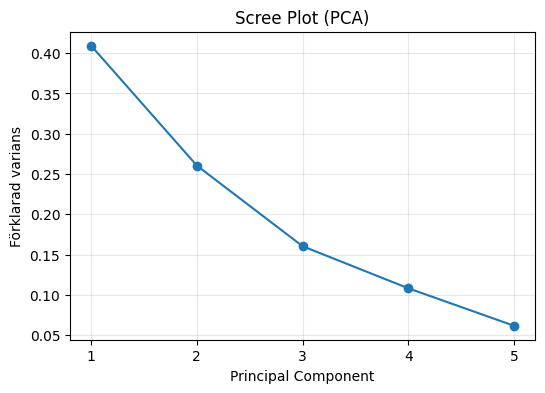

In [11]:
# Översikt Principle Components - tabell
# ========================
loading_df = pd.DataFrame(
    pca_full.components_,
    columns=features,
    index=[f"PC{i+1}" for i in range(len(features))]
)

print("Översikt Principle Components")
print("=====================================")
print(loading_df)
print("=====================================")

# Översikt Principle Components - Scree plot
# ========================
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(expl_var)+1), expl_var, marker='o')
plt.xticks(np.arange(1, len(expl_var)+1))
plt.xlabel("Principal Component")
plt.ylabel("Förklarad varians")
plt.title("Scree Plot (PCA)")
plt.grid(alpha=0.3)
plt.show()


### PCA med de två huvudkomponenter
Här visas den transformerade datan med hjälp av de två huvudkomponenterna (PC1 & PC2). Dessa komponenter fångar den maximala variansen, vilket ofta visar bättre klassseparation och struktur, vilket är hjälpsamt för att enklare att analysera data med många variablar.

- PC1: ålder, blodtryck och kolesterol (och lite vikt)
- PC 2: längd och vikt

PC1: 40.9%
PC2: 26.0%


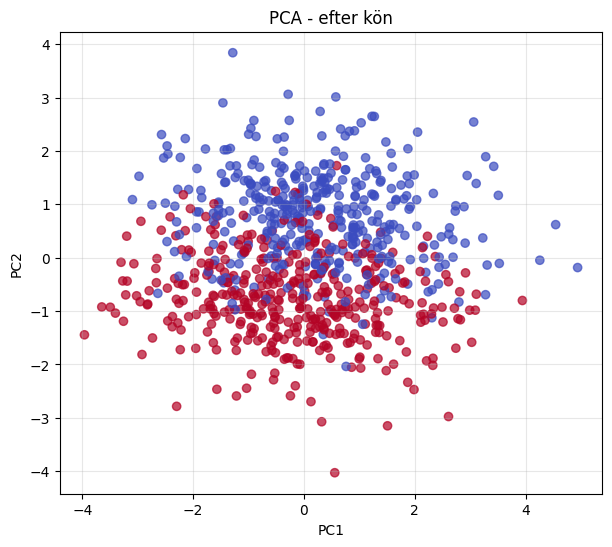

In [12]:
# PCA med 2 högsta huvudkomponenter (PC1 & PC2)
# ========================
pca = PCA(n_components=2)
PCs = pca.fit_transform(X_scaled)

print("=====================================")
print(f"PC1: {pca.explained_variance_ratio_[0] * 100:.1f}%")
print(f"PC2: {pca.explained_variance_ratio_[1] * 100:.1f}%")
print("=====================================")

# Visualiserar PC1 & PC2 i en Scatter plot
# ========================
plt.figure(figsize=(7,6))
plt.scatter(PCs[:,0], PCs[:,1], c=df["sex"].map({"M":0, "F":1}), cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - efter kön")
plt.grid(alpha=0.3)
plt.show()

### Tolkning av resultatet

- PC1 förklarar 40.9 % av variationen och har stora positiva bidrag från ålder, systoliskt blodtryck och kolesterol. Detta tyder på att PC1 kan tolkas som en allmän ”kardiovaskulär riskfaktor”, där högre värden indikerar högre riskprofil.
- PC2 förklarar 26.0 % av variationen och domineras av längd och vikt. PC2 verkar därför representera kroppsstorlek, där högre värden motsvarar längre och tyngre personer.

PCA-grafen visar att:
- Det är en större spridning längs PC1 än PC2, vilket är väntat eftersom PC1 förklarar mest varians (40.9 %) och representeras av ålder, blodtryck och kolesterol. Det betyder att dessa faktorer varierar mer mellan personer än kroppsstorlek, som PC2 representerar. 
- Män klustrar högre längs PC2-axeln, vilket betyder att män är i snitt längre och tyngre än kvinnor vilket ger en tydlig könsseperation vertikalt i grafen. 
- Liten eller ingen skilland mellan kön längs PC1-axeln vilket betyder att ålder, blodtryck och kolesterol skiljer sig inte tydligt mellan könen i detta dataset.

## Utökad analys - samband

Vi vill vidare fördjupa analysen och titta på samabandet mellan systoliskt blodtryck och ålder, samt systoliskt blodtryck och vikt. För dett använder vi oss av linjär regression som är en statistisk metod för att modellera samband mellan en beroende variabel och en given uppsättning oberoende variabler. Nedan visas två separata enkla linjära regressioner där sambanden illustreras. 

**Källa**: *Videolektioner från kursen Pythonprogrammering och statistisk dataanalys*, *[Geeks for geeks - Linear Regression (Python Implementation)](https://www.geeksforgeeks.org/machine-learning/linear-regression-python-implementation/)*

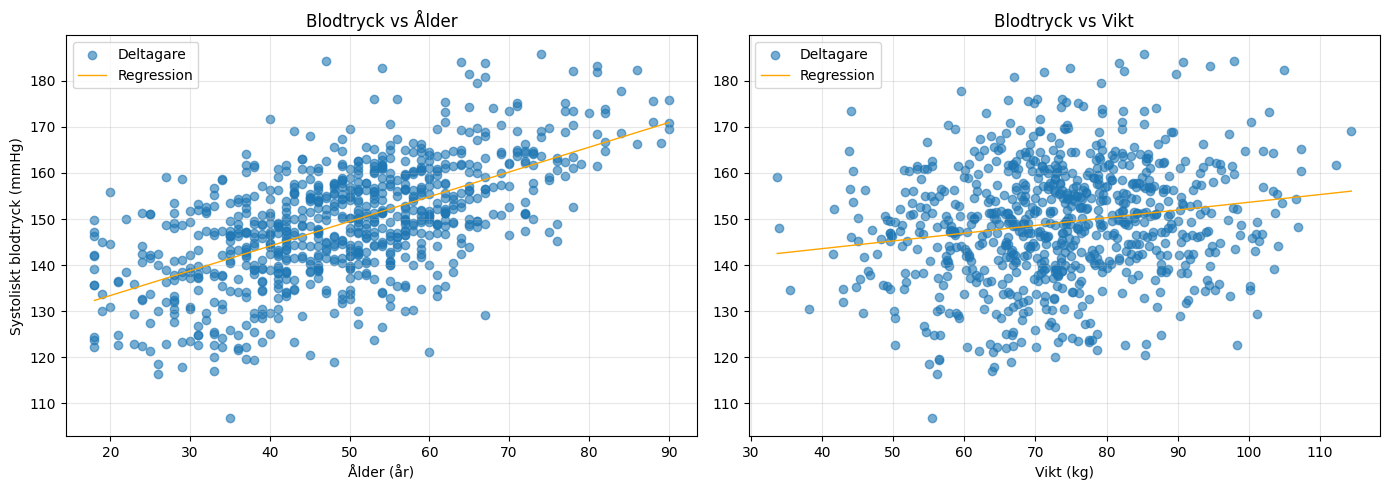

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. BP vs Age
# ------------------------
x_age = df[["age"]].values
y = df["systolic_bp"].values

model_age = LinearRegression()
model_age.fit(x_age, y)

# Linje för Age
x_line_age = np.linspace(x_age.min(), x_age.max(), 100).reshape(-1, 1)
y_line_age = model_age.predict(x_line_age)

axes[0].scatter(x_age, y, alpha=0.6, label="Deltagare")
axes[0].plot(x_line_age, y_line_age, color="orange", linewidth=1, label="Regression")
axes[0].set_xlabel("Ålder (år)")
axes[0].set_ylabel("Systoliskt blodtryck (mmHg)")
axes[0].set_title("Blodtryck vs Ålder")
axes[0].grid(alpha=0.3)
axes[0].legend()

# 2. BP vs Weight
# ------------------------
x_weight = df[["weight"]].values

model_weight = LinearRegression()
model_weight.fit(x_weight, y)

# Linje för Weight
x_line_weight = np.linspace(x_weight.min(), x_weight.max(), 100).reshape(-1, 1)
y_line_weight = model_weight.predict(x_line_weight)

axes[1].scatter(x_weight, y, alpha=0.6, label="Deltagare")
axes[1].plot(x_line_weight, y_line_weight, color="orange", linewidth=1, label="Regression")
axes[1].set_xlabel("Vikt (kg)")
axes[1].set_title("Blodtryck vs Vikt")
axes[1].grid(alpha=0.3)
axes[1].legend()


plt.tight_layout()
plt.show()

### Tolkning av resultatet

Ålder visar ett tydligt och relativt starkt samband med systoliskt blodtryck: äldre personer har högre blodtryck. Vikt har bara ett svagt samband – tyngre personer har en liten tendens att ha högre blodtryck men variationen är stor, vilket gör vikt till en betydligt sämre prediktor än ålder.